<a href="https://colab.research.google.com/github/sunweihao1997/DL_ENSO/blob/master/Machine_Learning_typhoon_predictionv4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🌀 台风频数预测模型 v3.0 (多模型对比版)

## 支持的机器学习模型
1. **SVR** - 支持向量回归
2. **Gaussian Process** - 高斯过程回归
3. **KNN** - K近邻回归
4. **Poisson** - 泊松回归
5. **Ridge** - 岭回归
6. **Random Forest** - 随机森林

---
⏱️ **预计运行时间**: 5-10分钟（取决于参数搜索空间）

## 1️⃣ 环境配置

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from itertools import product

from sklearn.svm import SVR
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, Matern
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Ridge, PoissonRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

print("✅ 环境配置完成！")

✅ 环境配置完成！


## 2️⃣ 上传数据

In [2]:
from google.colab import files
print("请上传: typhoon_count.csv 和 MEI/PDO/IOD/QBO 的NC文件")
uploaded = files.upload()
print(f"\n✅ 已上传 {len(uploaded)} 个文件")

请上传: typhoon_count.csv 和 MEI/PDO/IOD/QBO 的NC文件


Saving iod_ersst_v5.nc to iod_ersst_v5 (1).nc
Saving mei_v2.nc to mei_v2 (1).nc
Saving pdo_ersst_v5.nc to pdo_ersst_v5 (1).nc
Saving qbo.nc to qbo (1).nc
Saving typhoon_count.csv to typhoon_count (1).csv

✅ 已上传 5 个文件


## 3️⃣ 检查NC文件

In [3]:
for f in [f for f in os.listdir('.') if f.endswith('.nc')]:
    ds = xr.open_dataset(f)
    print(f"{f}: 变量={list(ds.data_vars)}")
    ds.close()

iod_ersst_v5.nc: 变量=['iod']
pdo_ersst_v5 (1).nc: 变量=['pdo']
pdo_ersst_v5.nc: 变量=['pdo']
qbo (1).nc: 变量=['value']
mei_v2.nc: 变量=['mei']
qbo.nc: 变量=['value']
mei_v2 (1).nc: 变量=['mei']
iod_ersst_v5 (1).nc: 变量=['iod']


## 4️⃣ 配置参数 ⚠️

In [4]:
class Config:
    # 数据文件
    TYPHOON_DATA_PATH = 'typhoon_count.csv'
    MEI_NC_PATH = 'mei_v2.nc'      # ← 修改
    PDO_NC_PATH = 'pdo_ersst_v5.nc'      # ← 修改
    IOD_NC_PATH = 'iod_ersst_v5.nc'      # ← 修改
    QBO_NC_PATH = 'qbo.nc'      # ← 修改

    # NC变量名
    MEI_VAR_NAME = 'mei'        # ← 修改
    PDO_VAR_NAME = 'pdo'
    IOD_VAR_NAME = 'iod'
    QBO_VAR_NAME = 'value'
    TIME_VAR_NAME = 'time'

    # 时间范围
    START_YEAR = 1980
    END_YEAR = 2024
    PREDICT_YEAR = 2025
    TEST_SPLIT_YEAR = 2015
    CV_N_SPLITS = 3

    # 要使用的模型
    MODELS_TO_USE = ['SVR', 'GaussianProcess', 'KNN', 'Poisson', 'Ridge', 'RandomForest']

    # 超参数搜索空间（中等版，约20-30分钟）
    PARAM_GRIDS = {
        'SVR': {
            'C': [0.1, 1, 10, 100],
            'epsilon': [0.01, 0.1, 0.5],
            'kernel': ['rbf', 'linear', 'poly'],
            'gamma': ['scale', 'auto', 0.01, 0.1],
        },
        'GaussianProcess': {
            'alpha': [1e-8, 1e-5, 1e-2, 0.1],
            'kernel_type': ['RBF', 'Matern', 'RationalQuadratic'],
            'length_scale': [0.5, 1.0, 2.0],
        },
        'KNN': {
            'n_neighbors': [3, 5, 7, 9, 11],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan'],
        },
        'Poisson': {
            'alpha': [0.001, 0.01, 0.1, 0.5, 1.0, 2.0],
            'fit_intercept': [True, False],
        },
        'Ridge': {
            'alpha': [0.01, 0.1, 0.5, 1.0, 5.0, 10.0, 50.0],
            'solver': ['auto', 'svd', 'lsqr'],
        },
        'RandomForest': {
            'n_estimators': [50, 100, 200],
            'max_depth': [2,  4,  6],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 3],
            'max_features': ['sqrt', 'log2', 0.5],
        },
    }

    REGIONS = ['South China Sea', 'Eastern China Sea', 'Japan Sea', 'Yellow Sea']
    USE_TREND_FEATURES = True
    OUTPUT_DIR = 'model_outputs'

os.makedirs(Config.OUTPUT_DIR, exist_ok=True)
print("✅ 配置完成")
print(f"   模型: {Config.MODELS_TO_USE}")

✅ 配置完成
   模型: ['SVR', 'GaussianProcess', 'KNN', 'Poisson', 'Ridge', 'RandomForest']


## 5️⃣ 数据加载模块

In [5]:
class DataLoader:
    def __init__(self, config):
        self.config = config
        self.typhoon_data = None
        self.climate_indices = None

    def load_typhoon_data(self):
        print("加载台风数据...")
        self.typhoon_data = pd.read_csv(self.config.TYPHOON_DATA_PATH)
        print(f"  ✓ {len(self.typhoon_data)} 条记录")
        return self.typhoon_data

    def load_climate_index(self, path, var_name, name):
        try:
            ds = xr.open_dataset(path)
            if var_name not in ds.data_vars:
                var_name = list(ds.data_vars)[0]
            df = ds[var_name].to_dataframe().reset_index()
            df['year'] = pd.to_datetime(df['time']).dt.year
            df['month'] = pd.to_datetime(df['time']).dt.month
            df['value'] = df[var_name]
            ds.close()
            return df[['year', 'month', 'value']]
        except Exception as e:
            print(f"  ! {name}加载失败: {e}")
            return None

    def load_all_climate_indices(self):
        print("加载气候指数...")
        self.climate_indices = {}
        for name, path, var in [
            ('MEI', self.config.MEI_NC_PATH, self.config.MEI_VAR_NAME),
            ('PDO', self.config.PDO_NC_PATH, self.config.PDO_VAR_NAME),
            ('IOD', self.config.IOD_NC_PATH, self.config.IOD_VAR_NAME),
            ('QBO', self.config.QBO_NC_PATH, self.config.QBO_VAR_NAME)
        ]:
            data = self.load_climate_index(path, var, name)
            if data is not None:
                self.climate_indices[name] = data
                print(f"  ✓ {name}")
        return self.climate_indices

    def calc_avg(self, data, year, months):
        mask = (data['year'] == year) & (data['month'].isin(months))
        vals = data.loc[mask, 'value']
        return vals.mean() if len(vals) >= 2 else np.nan

    def build_feature_matrix(self):
        print("构建特征矩阵...")
        years = [y for y in self.typhoon_data['Year'].unique()
                 if self.config.START_YEAR <= y <= self.config.END_YEAR]

        records = []
        for year in sorted(years):
            rec = {'Year': year}
            prev = year - 1
            for idx, data in self.climate_indices.items():
                ond = self.calc_avg(data, prev, [10, 11, 12])
                rec[f'{idx}_OND'] = ond
                if self.config.USE_TREND_FEATURES:
                    jas = self.calc_avg(data, prev, [7, 8, 9])
                    rec[f'{idx}_TREND'] = ond - jas if not np.isnan(ond) and not np.isnan(jas) else np.nan
            if 'MEI' in self.climate_indices:
                rec['MEI_Current_JASO'] = self.calc_avg(self.climate_indices['MEI'], year, [7,8,9,10])
            records.append(rec)

        df = pd.DataFrame(records)
        pivot = self.typhoon_data.pivot_table(index='Year', columns='Region',
                                              values='Typhoon_Count', aggfunc='sum').reset_index()
        for col in pivot.columns:
            if col != 'Year':
                pivot = pivot.rename(columns={col: f'Target_{col}'})

        result = df.merge(pivot, on='Year').dropna()
        print(f"  ✓ {len(result)} 个样本")
        return result

print("✅ 数据加载模块定义完成")

✅ 数据加载模块定义完成


## 6️⃣ 模型工厂

In [6]:
class ModelFactory:
    @staticmethod
    def create(name, params):
        if name == 'SVR':
            return SVR(C=params.get('C',1), epsilon=params.get('epsilon',0.1),
                      kernel=params.get('kernel','rbf'), gamma='scale')
        elif name == 'GaussianProcess':
            kt = params.get('kernel_type', 'RBF')
            kernel = ConstantKernel(1.0) * (RBF(1.0) if kt=='RBF' else Matern(1.0, nu=1.5))
            return GaussianProcessRegressor(kernel=kernel, alpha=params.get('alpha',1e-10), random_state=42)
        elif name == 'KNN':
            return KNeighborsRegressor(n_neighbors=params.get('n_neighbors',5),
                                       weights=params.get('weights','uniform'))
        elif name == 'Poisson':
            return PoissonRegressor(alpha=params.get('alpha',1.0), max_iter=1000)
        elif name == 'Ridge':
            return Ridge(alpha=params.get('alpha',1.0))
        elif name == 'RandomForest':
            return RandomForestRegressor(n_estimators=params.get('n_estimators',100),
                                        max_depth=params.get('max_depth',None),
                                        min_samples_split=params.get('min_samples_split',2),
                                        random_state=42, n_jobs=-1)

    @staticmethod
    def get_param_combos(grid):
        keys, vals = list(grid.keys()), list(grid.values())
        return [dict(zip(keys, v)) for v in product(*vals)]

print("✅ 模型工厂定义完成")

✅ 模型工厂定义完成


## 7️⃣ 多模型预测系统

In [7]:
class MultiModelSystem:
    def __init__(self, config):
        self.config = config
        self.results = {}
        self.best_models = {}
        self.trained = {}
        self.scalers = {}
        self.correction = {}
        self.feature_cols = None

    def cv(self, X, y, model_name, params, n_splits=5):
        tscv = TimeSeriesSplit(n_splits=n_splits)
        rmses = []
        for tr, val in tscv.split(X):
            sc = StandardScaler()
            Xtr = sc.fit_transform(X[tr])
            Xval = sc.transform(X[val])
            ytr = np.maximum(y[tr], 0) if model_name == 'Poisson' else y[tr]
            try:
                m = ModelFactory.create(model_name, params)
                m.fit(Xtr, ytr)
                pred = np.maximum(m.predict(Xval), 0)
                rmses.append(np.sqrt(mean_squared_error(y[val], pred)))
            except:
                rmses.append(999)
        return np.mean(rmses), np.std(rmses)

    def search(self, X, y, model_name, grid):
        combos = ModelFactory.get_param_combos(grid)
        best_rmse, best_params = float('inf'), None
        for p in combos:
            rmse, _ = self.cv(X, y, model_name, p, self.config.CV_N_SPLITS)
            if rmse < best_rmse:
                best_rmse, best_params = rmse, p
        return best_params, best_rmse

    def train_region(self, data, region, feat_cols):
        target = f'Target_{region}'
        if target not in data.columns:
            return None

        X, y = data[feat_cols].values, data[target].values
        years = data['Year'].values
        tr_mask = years < self.config.TEST_SPLIT_YEAR
        te_mask = years >= self.config.TEST_SPLIT_YEAR

        Xtr, Xte = X[tr_mask], X[te_mask]
        ytr, yte = y[tr_mask], y[te_mask]

        sc = StandardScaler()
        Xtr_s = sc.fit_transform(Xtr)
        Xte_s = sc.transform(Xte)
        self.scalers[region] = sc

        print(f"\n  === {region} ===")
        model_res = {}
        for mn in self.config.MODELS_TO_USE:
            print(f"    {mn}...", end=" ")
            grid = self.config.PARAM_GRIDS.get(mn, {})
            bp, cv_rmse = self.search(Xtr, ytr, mn, grid) if grid else ({}, self.cv(Xtr, ytr, mn, {}, self.config.CV_N_SPLITS)[0])
            print(f"CV={cv_rmse:.2f}")
            model_res[mn] = {'params': bp, 'cv_rmse': cv_rmse}

        # 选最优
        best_mn = min(model_res, key=lambda m: model_res[m]['cv_rmse'])
        best_p = model_res[best_mn]['params']
        print(f"  🏆 最优: {best_mn}")

        # 训练最终模型
        ytr_f = np.maximum(ytr, 0) if best_mn == 'Poisson' else ytr
        final = ModelFactory.create(best_mn, best_p)
        final.fit(Xtr_s, ytr_f)

        ytr_pred = np.maximum(final.predict(Xtr_s), 0)
        yte_pred = np.maximum(final.predict(Xte_s), 0)

        test_rmse = np.sqrt(mean_squared_error(yte, yte_pred))
        test_r2 = r2_score(yte, yte_pred)
        print(f"     Test RMSE={test_rmse:.2f}, R²={test_r2:.2f}")

        self.best_models[region] = best_mn
        self.trained[region] = {best_mn: final}

        # 训练所有模型用于对比
        for mn in self.config.MODELS_TO_USE:
            if mn not in self.trained[region]:
                try:
                    yt = np.maximum(ytr, 0) if mn == 'Poisson' else ytr
                    m = ModelFactory.create(mn, model_res[mn]['params'])
                    m.fit(Xtr_s, yt)
                    self.trained[region][mn] = m
                    pred = np.maximum(m.predict(Xte_s), 0)
                    model_res[mn]['test_rmse'] = np.sqrt(mean_squared_error(yte, pred))
                except:
                    model_res[mn]['test_rmse'] = 999

        model_res[best_mn]['test_rmse'] = test_rmse

        # ENSO修正
        if 'MEI_Current_JASO' in data.columns:
            mei = data.loc[tr_mask, 'MEI_Current_JASO'].values
            res = ytr - ytr_pred
            valid = ~np.isnan(mei)
            if valid.sum() > 5:
                slope, inter = np.polyfit(mei[valid], res[valid], 1)
                self.correction[region] = {'slope': slope, 'intercept': inter}

        self.results[region] = {
            'models': model_res, 'best': best_mn, 'test_rmse': test_rmse, 'test_r2': test_r2,
            'y_train': ytr, 'y_train_pred': ytr_pred, 'y_test': yte, 'y_test_pred': yte_pred,
            'years_train': years[tr_mask], 'years_test': years[te_mask]
        }

    def train_all(self, data):
        self.feature_cols = [c for c in data.columns if '_OND' in c or '_TREND' in c]
        print(f"特征: {self.feature_cols}")
        for region in self.config.REGIONS:
            self.train_region(data, region, self.feature_cols)

    def predict(self, features, enso=None):
        fcols = sorted([c for c in features if '_OND' in c or '_TREND' in c])
        X = np.array([[features[c] for c in fcols]])
        preds = {}
        for region, mn in self.best_models.items():
            Xs = self.scalers[region].transform(X)
            base = float(np.maximum(self.trained[region][mn].predict(Xs), 0)[0])
            corr = 0
            if enso and region in self.correction:
                corr = self.correction[region]['slope'] * enso + self.correction[region]['intercept']
            final = max(0, base + corr)
            preds[region] = {'model': mn, 'base': base, 'corr': corr, 'final': round(final)}
        return preds

    def comparison_table(self):
        rows = []
        for region, res in self.results.items():
            for mn, mr in res['models'].items():
                rows.append({
                    'Region': region, 'Model': mn, 'CV_RMSE': mr['cv_rmse'],
                    'Test_RMSE': mr.get('test_rmse', np.nan),
                    'Best': '★' if mn == res['best'] else ''
                })
        return pd.DataFrame(rows)

print("✅ 多模型系统定义完成")

✅ 多模型系统定义完成


## 8️⃣ 运行训练

In [8]:
# 加载数据
loader = DataLoader(Config)
loader.load_typhoon_data()
loader.load_all_climate_indices()
data = loader.build_feature_matrix()

print("\n" + "="*50)
display(data.head())

加载台风数据...
  ✓ 463 条记录
加载气候指数...
  ✓ MEI
  ✓ PDO
  ✓ IOD
  ✓ QBO
构建特征矩阵...
  ✓ 37 个样本



,Year,MEI_OND,MEI_TREND,PDO_OND,PDO_TREND,IOD_OND,IOD_TREND,QBO_OND,QBO_TREND,MEI_Current_JASO,Target_Eastern China Sea,Target_Japan Sea,Target_South China Sea,Target_Yellow Sea
0,1980,0.463333,0.213333,0.580000,0.170000,-0.316667,-0.183333,-20.836668,1.233334,0.1625,5.0,3.0,18.0,2.0
1,1981,-0.056667,-0.263333,0.666667,0.753333,-0.130000,0.030000,11.660000,1.320001,-0.2875,7.0,7.0,14.0,4.0
2,1982,-0.210000,0.120000,0.346667,-0.053333,-0.270000,0.183333,-10.486667,-3.136667,1.7525,1.0,4.0,11.0,1.0
4,1984,-0.500000,-0.486667,1.196667,-0.176667,0.000000,-0.500000,-10.610000,-4.723333,-0.2175,7.0,4.0,14.0,5.0
5,1985,-0.353333,-0.126667,0.483333,0.536667,-0.253333,0.086667,-14.313333,11.930001,-0.3075,11.0,4.0,16.0,5.0


In [9]:
# 训练多模型系统
print("⏳ 开始训练（可能需要几分钟）...")
system = MultiModelSystem(Config)
system.train_all(data)

print("\n" + "="*50)
print("✅ 训练完成！")

⏳ 开始训练（可能需要几分钟）...
特征: ['MEI_OND', 'MEI_TREND', 'PDO_OND', 'PDO_TREND', 'IOD_OND', 'IOD_TREND', 'QBO_OND', 'QBO_TREND']

  === South China Sea ===
    SVR... CV=2.81
    GaussianProcess... CV=3.53
    KNN... CV=2.82
    Poisson... CV=5.59
    Ridge... CV=2.78
    RandomForest... CV=2.58
  🏆 最优: RandomForest
     Test RMSE=3.71, R²=-0.51

  === Eastern China Sea ===
    SVR... CV=2.78
    GaussianProcess... CV=3.60
    KNN... CV=2.88
    Poisson... CV=6.64
    Ridge... CV=2.94
    RandomForest... CV=3.09
  🏆 最优: SVR
     Test RMSE=2.77, R²=-0.02

  === Japan Sea ===
    SVR... CV=1.67
    GaussianProcess... CV=2.23
    KNN... CV=1.73
    Poisson... CV=2.00
    Ridge... CV=1.77
    RandomForest... CV=1.74
  🏆 最优: SVR
     Test RMSE=1.17, R²=-0.03

  === Yellow Sea ===
    SVR... CV=1.52
    GaussianProcess... CV=2.02
    KNN... CV=1.65
    Poisson... CV=1.92
    Ridge... CV=1.66
    RandomForest... CV=1.61
  🏆 最优: SVR
     Test RMSE=1.43, R²=-0.06

✅ 训练完成！


## 9️⃣ 查看结果

In [10]:
# 模型对比表
comparison = system.comparison_table()
print("\n各海区模型对比:")
display(comparison)

# 保存
comparison.to_csv(f'{Config.OUTPUT_DIR}/model_comparison.csv', index=False)


各海区模型对比:


,Region,Model,CV_RMSE,Test_RMSE,Best
0,South China Sea,SVR,2.805762,3.658457,
1,South China Sea,GaussianProcess,3.532325,4.728061,
2,South China Sea,KNN,2.820835,3.603979,
3,South China Sea,Poisson,5.590426,3.213609,
4,South China Sea,Ridge,2.775417,3.312910,
5,South China Sea,RandomForest,2.577625,3.713524,★
6,Eastern China Sea,SVR,2.782741,2.773983,★
7,Eastern China Sea,GaussianProcess,3.599106,3.286058,
8,Eastern China Sea,KNN,2.879347,2.923468,
9,Eastern China Sea,Poisson,6.637704,3.279324,


In [11]:
# 最优模型汇总
print("\n🏆 各海区最优模型:")
for region, res in system.results.items():
    print(f"  {region}: {res['best']} (Test RMSE={res['test_rmse']:.2f})")


🏆 各海区最优模型:
  South China Sea: RandomForest (Test RMSE=3.71)
  Eastern China Sea: SVR (Test RMSE=2.77)
  Japan Sea: SVR (Test RMSE=1.17)
  Yellow Sea: SVR (Test RMSE=1.43)


## 🔟 可视化

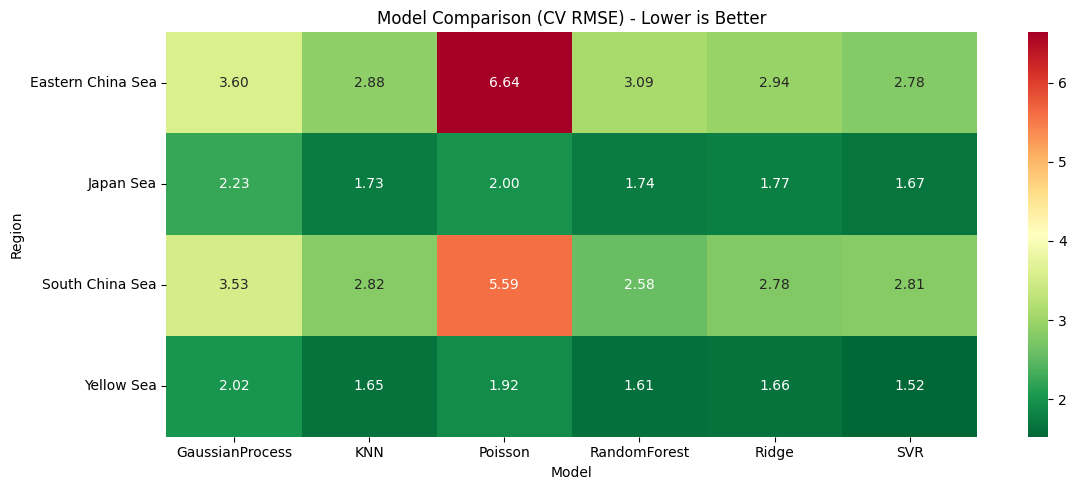

In [12]:
# 热力图
pivot = comparison.pivot(index='Region', columns='Model', values='CV_RMSE')
plt.figure(figsize=(12, 5))
sns.heatmap(pivot, annot=True, fmt='.2f', cmap='RdYlGn_r')
plt.title('Model Comparison (CV RMSE) - Lower is Better')
plt.tight_layout()
plt.savefig(f'{Config.OUTPUT_DIR}/heatmap.png', dpi=150)
plt.show()

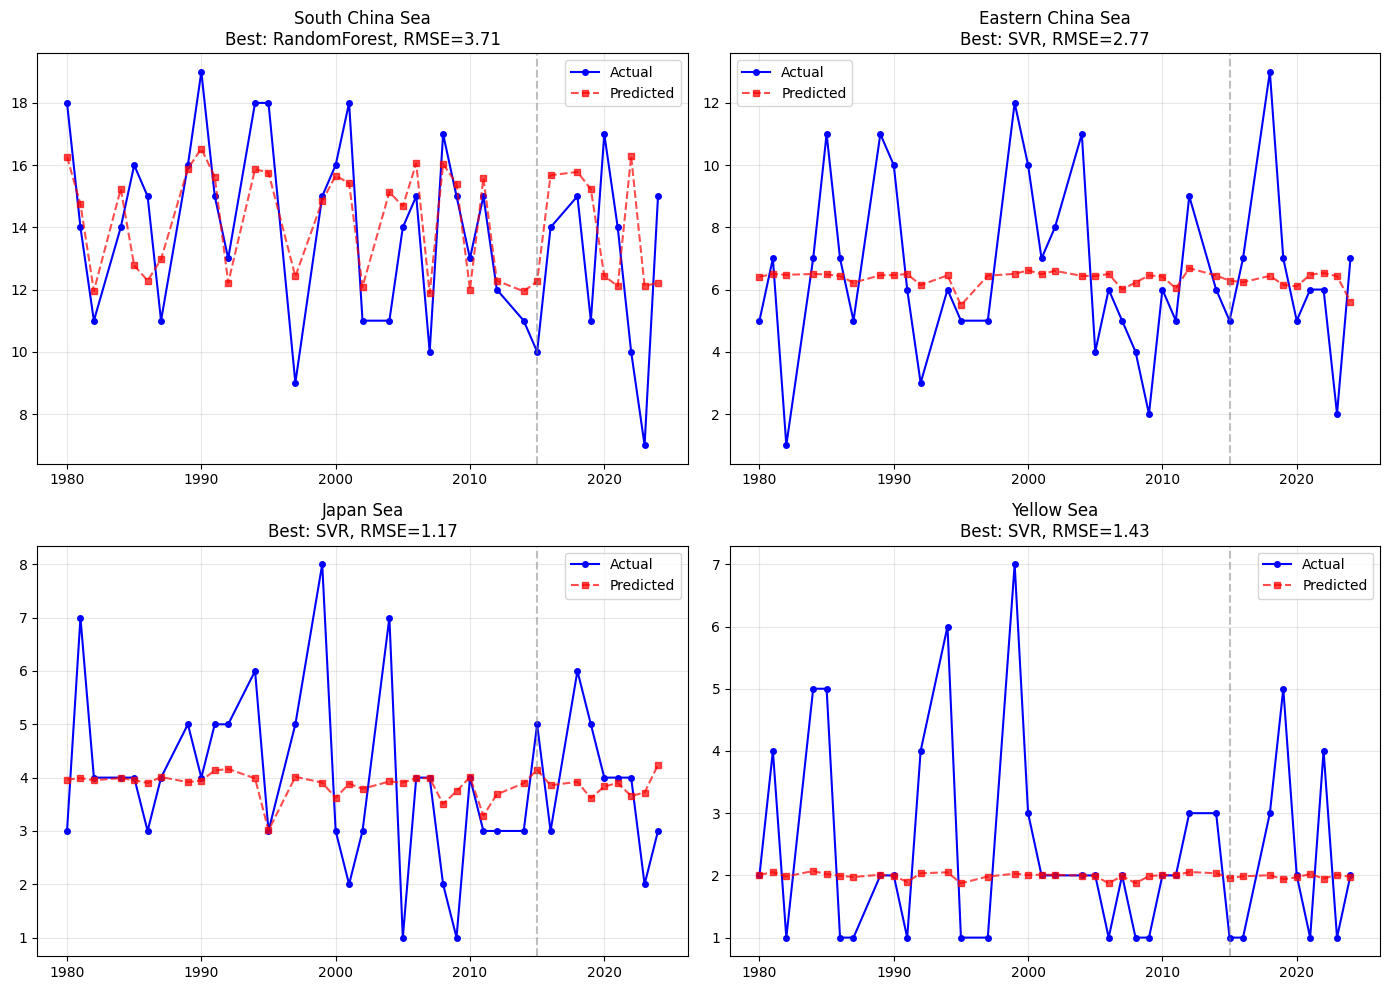

In [14]:
# 预测vs实际
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
for idx, (region, res) in enumerate(system.results.items()):
    if idx >= 4: break
    ax = axes.flatten()[idx]
    yrs = np.concatenate([res['years_train'], res['years_test']])
    act = np.concatenate([res['y_train'], res['y_test']])
    pred = np.concatenate([res['y_train_pred'], res['y_test_pred']])
    ax.plot(yrs, act, 'b-o', label='Actual', ms=4)
    ax.plot(yrs, pred, 'r--s', label='Predicted', ms=4, alpha=0.7)
    ax.axvline(Config.TEST_SPLIT_YEAR, color='gray', ls='--', alpha=0.5)
    ax.set_title(f"{region}\nBest: {res['best']}, RMSE={res['test_rmse']:.2f}")
    ax.legend()
    ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f'{Config.OUTPUT_DIR}/predictions.png', dpi=150)
plt.show()